In [2]:
!pip install spotipy
!pip install pandas
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.6/255.6 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: pillow
    Found existing installation: Pillow 3.4.2
    Uninstalling Pillow-3.4.2:
      Successfully uninstalled Pillow-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 0.8.3 requires pandas<1.6,>=1.4.1, but you have pandas 2.1.4 which is incompatible.
autogluon-multimodal 0.8.3 requires pytorch-lightning<1.10.0,>=1.9.0, but you have pytorch-lightning 2.0.9 which is incompatible.
autogluon-multimodal 0.8.3 requires scikit-learn<1.4.1,>=1.1, but you have scikit-learn 1.4.2 which is incompatible.
autogluon-multimodal 0.8.3 requires torch<1.14,>=1.9, but you have torch 2.0.0.post104 which is incompatible.
autogluon-multimodal 0.8.3 requires torchmetr

In [3]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Replace with your Spotify API credentials
CLIENT_ID = 'b15e21f1740f426db674d3bcf7e12b8d'
CLIENT_SECRET = '01613442d19a4555a3bbed51c2dd861f'

# Spotify Authentication
auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [5]:
def get_playlist_tracks(playlist_id):
    tracks = []
    results = sp.playlist_tracks(playlist_id)
    tracks.extend(results['items'])
    
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    
    track_data = []
    for item in tracks:
        track = item['track']
        track_data.append({
            'name': track['name'],
            'id': track['id'],
            'popularity': track['popularity'],
            'artist': track['artists'][0]['name']
        })
    return pd.DataFrame(track_data)

# Example playlist (you can change this with your own playlist ID)
playlist_id = '37i9dQZF1DX4JAvHpjipBk'  # Replace with your playlist ID
tracks_df = get_playlist_tracks(playlist_id)
print(tracks_df.head())

                                            name                      id  \
0                                       GODSPEED  1HA5rqn1k4YQnJ9XxsnApd   
1                               just stand there  2D9a9CXeo3HFtVeaNlzp4a   
2                                            Ego  1mGM4dJe4v9DhBY3pRSpRj   
3                    Ruby Rosary (feat. J. Cole)  1lloYB6uHOTDmheiWsq4DL   
4  Someone In This Room (feat. Bailey Zimmerman)  3kvgQZmOgwjfVnuduPPDZG   

   popularity          artist  
0          60  Camila Cabello  
1          43    Fred again..  
2          38          Halsey  
3          45      A$AP Rocky  
4          32    Jessie Murph  


In [6]:
def get_audio_features(track_ids):
    audio_features = []
    for i in range(0, len(track_ids), 50):
        features = sp.audio_features(track_ids[i:i + 50])
        audio_features.extend(features)
    return pd.DataFrame(audio_features)

# Fetch audio features for the tracks
track_ids = tracks_df['id'].tolist()
audio_features_df = get_audio_features(track_ids)
print(audio_features_df.head())

# Merge audio features with the tracks DataFrame
playlist_df = tracks_df.merge(audio_features_df, on='id')
print(playlist_df.head())

   danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.387   0.445    5    -8.578     1       0.0464       0.73500   
1         0.564   0.864    5    -7.111     1       0.0506       0.02780   
2         0.582   0.951    7    -3.081     1       0.0679       0.00161   
3         0.663   0.647    7    -7.249     1       0.2890       0.79400   
4         0.480   0.338    3    -8.899     1       0.0346       0.48800   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000006     0.170    0.166  126.811  audio_features   
1          0.125000     0.134    0.290  130.023  audio_features   
2          0.000000     0.345    0.307  104.985  audio_features   
3          0.000000     0.100    0.432   78.584  audio_features   
4          0.000000     0.103    0.267  145.531  audio_features   

                       id                                   uri  \
0  1HA5rqn1k4YQnJ9XxsnApd  spotify:track:1HA5rqn1k4YQnJ9XxsnApd   
1  2D9a9CXeo

In [7]:
# Selecting relevant audio features
features = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']

# Standardizing the features
scaler = StandardScaler()
playlist_df[features] = scaler.fit_transform(playlist_df[features])

# Final DataFrame with important information
playlist_final_df = playlist_df[['name', 'artist'] + features]
print(playlist_final_df.head())

                                            name          artist  \
0                                       GODSPEED  Camila Cabello   
1                               just stand there    Fred again..   
2                                            Ego          Halsey   
3                    Ruby Rosary (feat. J. Cole)      A$AP Rocky   
4  Someone In This Room (feat. Bailey Zimmerman)    Jessie Murph   

   danceability    energy  speechiness  acousticness  instrumentalness  \
0     -1.315866 -1.208955    -0.555099      1.999711         -0.306021   
1     -0.160108  1.077549    -0.505417     -0.653491          0.876561   
2     -0.042574  1.552312    -0.300771     -0.751748         -0.306081   
3      0.486333 -0.106631     2.314677      2.221062         -0.306081   
4     -0.708604 -1.792859    -0.694685      1.073041         -0.306081   

   liveness   valence     tempo  
0 -0.003577 -1.318827  0.187053  
1 -0.306531 -0.744832  0.295486  
2  1.469117 -0.666139 -0.549767  
3 -0.59265

/tmp/ipykernel_653/3565805678.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  playlist_final_df['cluster'] = kmeans.fit_predict(playlist_final_df[features])


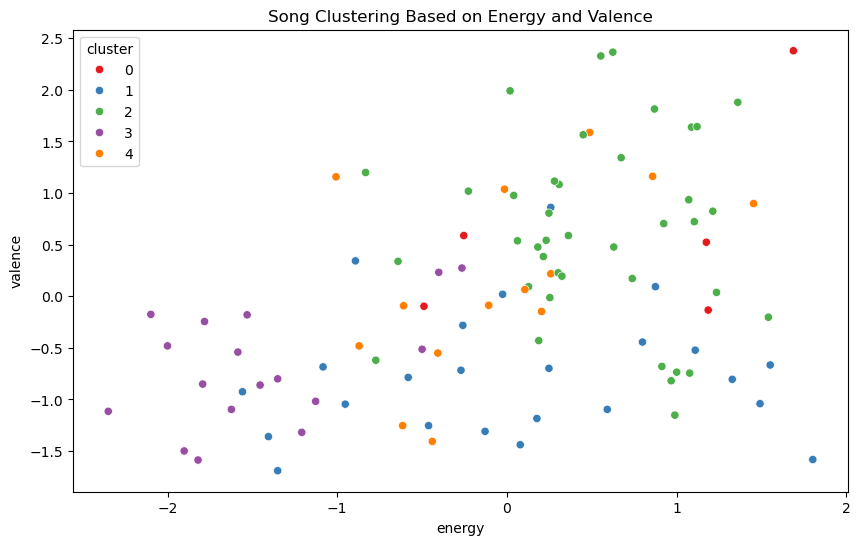

In [8]:
# Fit KMeans clustering to group songs into clusters
kmeans = KMeans(n_clusters=5, random_state=42)
playlist_final_df['cluster'] = kmeans.fit_predict(playlist_final_df[features])

# Visualizing the clusters
plt.figure(figsize=(10,6))
sns.scatterplot(x='energy', y='valence', hue='cluster', data=playlist_final_df, palette='Set1')
plt.title('Song Clustering Based on Energy and Valence')
plt.show()


In [9]:
def recommend_playlist(mood):
    # Defining basic moods to map to clusters (you can expand on this)
    mood_to_cluster = {
        'happy': 1,
        'sad': 2,
        'energetic': 3,
        'relaxed': 0,
        'party': 4
    }
    
    if mood.lower() in mood_to_cluster:
        cluster = mood_to_cluster[mood.lower()]
        recommended_songs = playlist_final_df[playlist_final_df['cluster'] == cluster]
        return recommended_songs[['name', 'artist']]
    else:
        return "Mood not recognized. Please try another mood."

# Example: Recommend a playlist for a 'relaxed' mood
mood = input("Enter your mood (e.g., happy, sad, energetic, relaxed, party): ")
recommended_songs = recommend_playlist(mood)
print(recommended_songs)


Enter your mood (e.g., happy, sad, energetic, relaxed, party):  happy


                                                 name            artist
2                                                 Ego            Halsey
15                                              Texas             keshi
16                        Wet Dreams (feat. Coop & G)         Flo Milli
19                                         TAKE ME IN         blink-182
22                                      PRETTIEST ONE    Destroy Lonely
24                                               Ashe              Ashe
26      Never Going Home Tonight (feat. Madison Love)      David Guetta
28                                             Want 2            Laila!
33                                    Til The Morning        Royel Otis
36                                         Lock Me Up  Mercer Henderson
48  Paint The Town Blue (from the series Arcane Le...          Ashnikko
50                              Ten (feat. Sexyy Red)           G Herbo
54                                             I Walk       Moun